In [1]:
# Step 1: Import and Load
import pandas as pd

# Load CSV
df = pd.read_csv('CarPrice.csv')

# Preview data
print(df.shape)
df.head()


(301, 9)


,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Selling_Price
0,ritz,2014,5.59,27000,Petrol,Dealer,Manual,0,3.35
1,sx4,2013,9.54,43000,Diesel,Dealer,Manual,0,4.75
2,ciaz,2017,9.85,6900,Petrol,Dealer,Manual,0,7.25
3,wagon r,2011,4.15,5200,Petrol,Dealer,Manual,0,2.85
4,swift,2014,6.87,42450,Diesel,Dealer,Manual,0,4.60


In [5]:
# Optional: rename columns for consistency
df.columns = df.columns.str.strip().str.replace(" ", "_")
df.rename(columns={
    'Present_P': 'Present_Price',
    'Kms_Drive': 'Kms_Driven',
    'Seller_Typ': 'Seller_Type'
}, inplace=True)


In [7]:
df.drop_duplicates(inplace=True)
print(df.isnull().sum())


Car_Name         0
Year             0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
Selling_Price    0
dtype: int64


In [9]:
# Drop Car_Name (text column, not useful for prediction)
df.drop(['Car_Name'], axis=1, inplace=True)

# Confirm columns after cleanup
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 300
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           299 non-null    int64  
 1   Present_Price  299 non-null    float64
 2   Kms_Driven     299 non-null    int64  
 3   Fuel_Type      299 non-null    object 
 4   Seller_Type    299 non-null    object 
 5   Transmission   299 non-null    object 
 6   Owner          299 non-null    int64  
 7   Selling_Price  299 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 21.0+ KB


In [11]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Categorical columns to encode
categorical_cols = ['Fuel_Type', 'Seller_Type', 'Transmission']

# Column transformer (OneHot for categoricals)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'  # numeric features stay as-is
)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate each
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.2f}")



Linear Regression
  RMSE: 2.52
  R² Score: 0.75

Random Forest
  RMSE: 3.74
  R² Score: 0.46

XGBoost
  RMSE: 2.26
  R² Score: 0.80


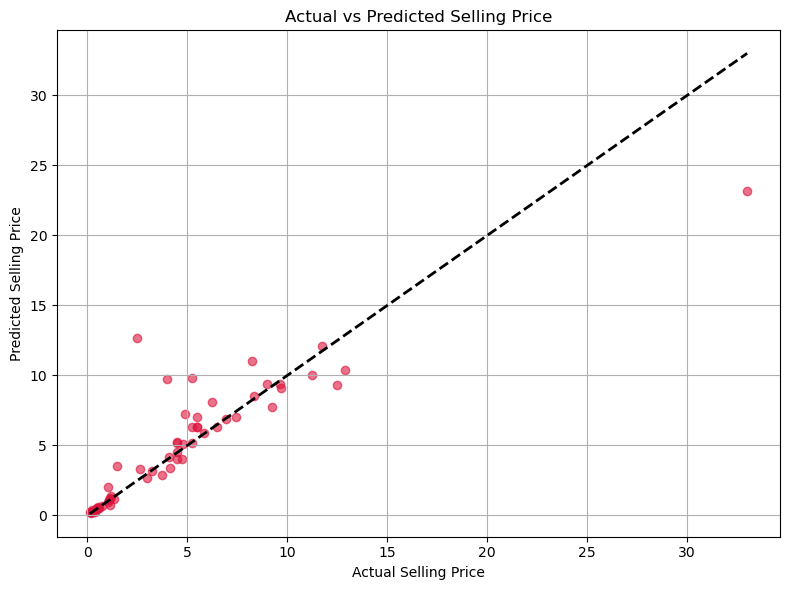

In [17]:
import matplotlib.pyplot as plt

# Choose best model (e.g., XGBoost for this example)
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='crimson', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.grid(True)
plt.tight_layout()
plt.show()


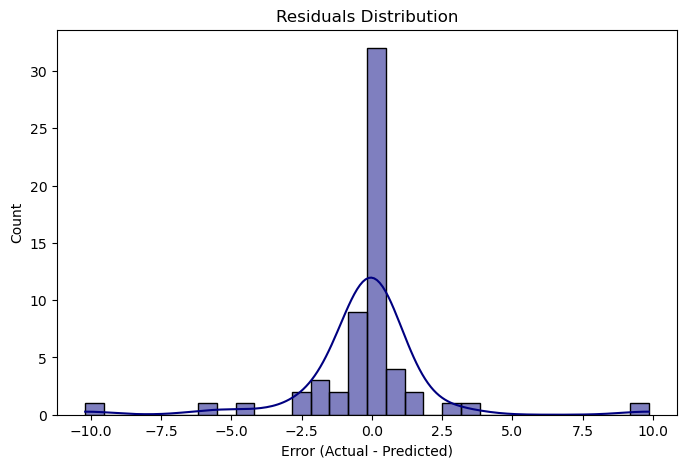

In [21]:
import seaborn as sns
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color='navy')
plt.title('Residuals Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_12360\1532849458.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Selling_Price', estimator='mean', ci=None)


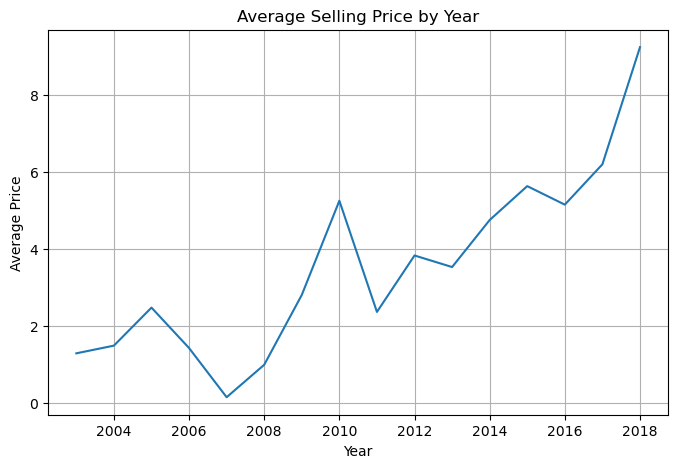

In [23]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='Year', y='Selling_Price', estimator='mean', ci=None)
plt.title('Average Selling Price by Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


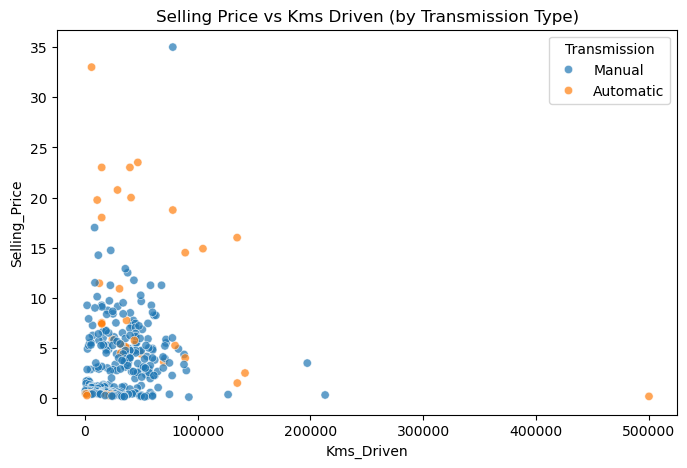

In [25]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Kms_Driven', y='Selling_Price', hue='Transmission', alpha=0.7)
plt.title('Selling Price vs Kms Driven (by Transmission Type)')
plt.show()


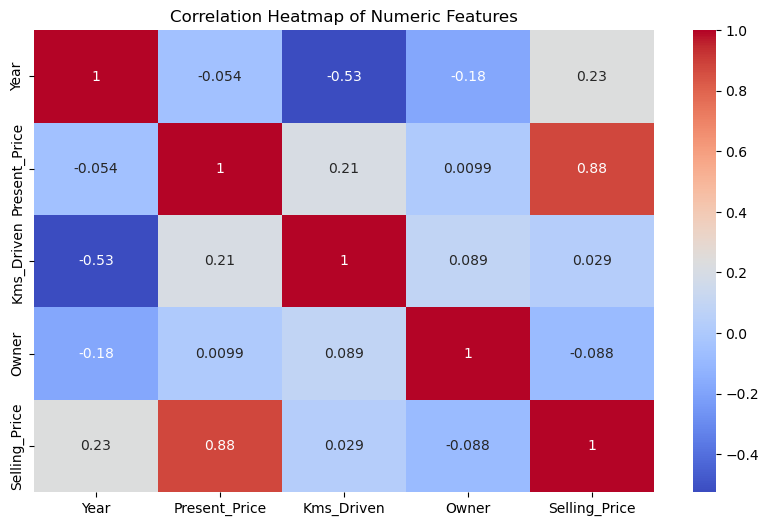

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Combine with pipeline
tuned_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', search)
])

tuned_pipeline.fit(X_train, y_train)
best_model = tuned_pipeline.named_steps['regressor'].best_estimator_
print("Best Parameters:", tuned_pipeline.named_steps['regressor'].best_params_)

# Evaluate
y_pred = tuned_pipeline.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
RMSE: 3.6880708103633926
R2 Score: 0.47224894602101664


In [33]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Build pipeline with preprocessing
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', xgb_search)
])

# Fit on training data
xgb_pipeline.fit(X_train, y_train)

# Best estimator
best_xgb = xgb_pipeline.named_steps['regressor'].best_estimator_
print("Best XGBoost Params:", xgb_pipeline.named_steps['regressor'].best_params_)

# Predict and evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n Tuned XGBoost Performance:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

 Tuned XGBoost Performance:
RMSE: 1.86
R² Score: 0.87


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Preprocessor
categorical_cols = ['Fuel_Type', 'Seller_Type', 'Transmission']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

# Model dictionary with preprocessing pipeline
models = {
    'Linear Regression': Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost (Tuned)': xgb_pipeline  # already fitted and tuned!
}

# Evaluate all models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([name, round(rmse, 2), round(r2, 2)])

# Create results table
comparison_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R² Score'])
comparison_df = comparison_df.sort_values(by='R² Score', ascending=False).reset_index(drop=True)
print(comparison_df)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
               Model  RMSE  R² Score
0    XGBoost (Tuned)  1.90      0.86
1  Linear Regression  2.52      0.75
2      Random Forest  3.74      0.46


In [39]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [43]:
# Transform the training set using the preprocessor only
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for SHAP
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)


In [45]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.Explainer(best_xgb)

# Calculate SHAP values
shap_values = explainer(X_train_df)


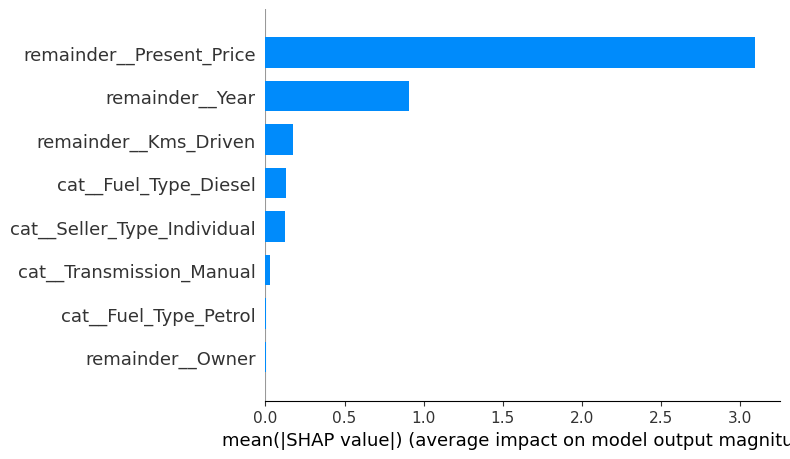

In [47]:
shap.summary_plot(shap_values, X_train_df, plot_type="bar")


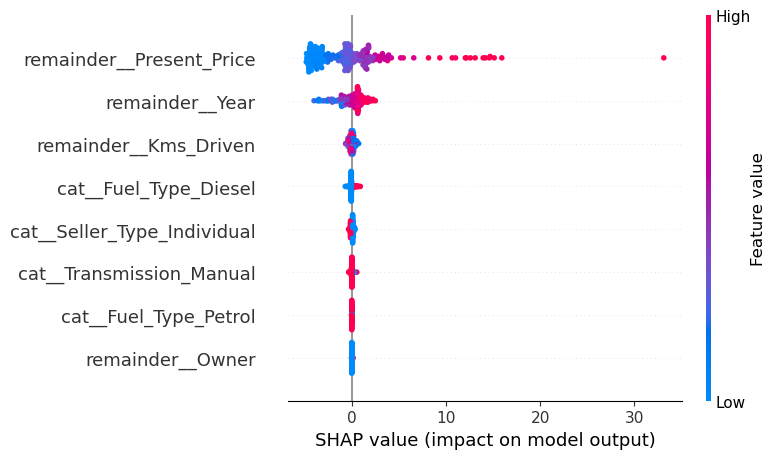

In [49]:
shap.summary_plot(shap_values, X_train_df)


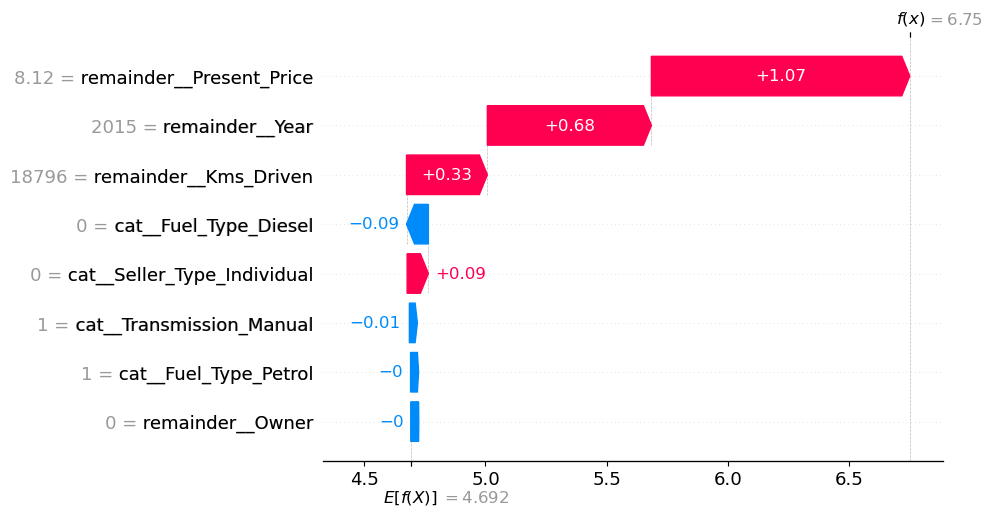

In [51]:
# Explain 1st sample
shap.plots.waterfall(shap_values[0])


C:\Users\DELL\AppData\Local\Temp\ipykernel_12360\3766146487.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='mako')


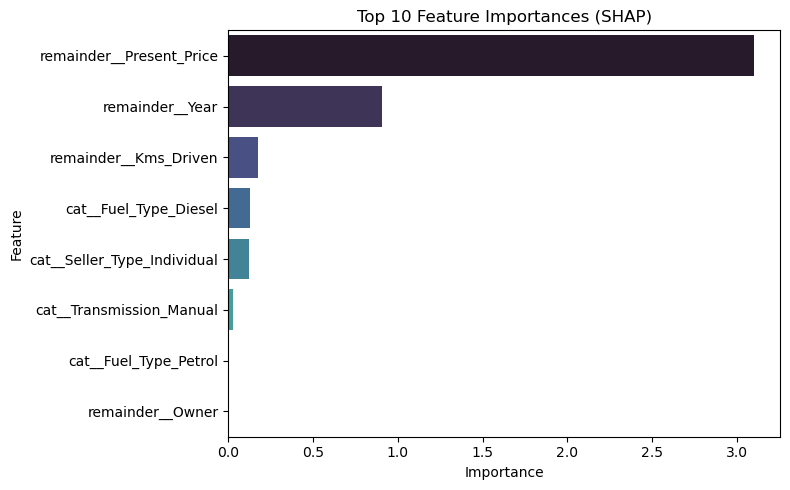

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Mean absolute SHAP values
shap_vals = np.abs(shap_values.values).mean(axis=0)
feature_names = X_train_df.columns

# Top 10
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': shap_vals})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='mako')
plt.title('Top 10 Feature Importances (SHAP)')
plt.tight_layout()
plt.show()


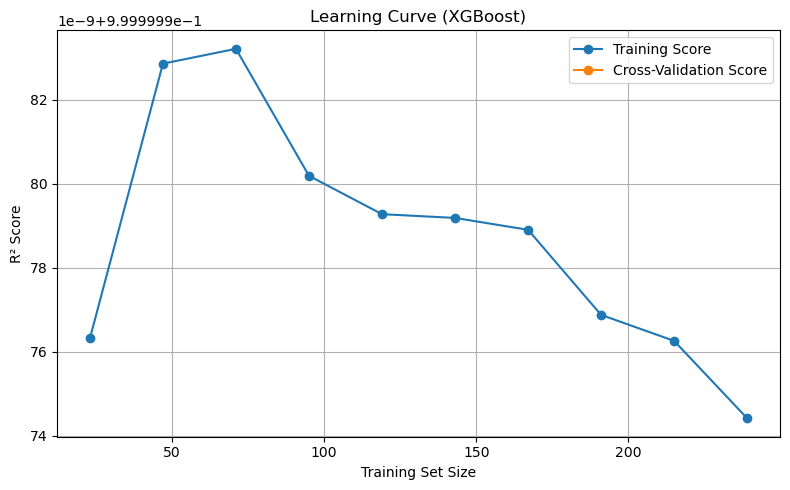

In [55]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the best XGBoost model in a pipeline
from sklearn.pipeline import Pipeline

xgb_learning_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', best_xgb)
])

# Get learning curve values
train_sizes, train_scores, val_scores = learning_curve(
    xgb_learning_pipeline, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2',
    cv=5,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Cross-Validation Score')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
from sklearn.model_selection import cross_val_score

# Wrap XGBoost in pipeline (already done)
xgb_cv_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', best_xgb)
])

# Get cross-validation R² scores
cv_scores = cross_val_score(
    xgb_cv_pipeline, X, y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Display results
print(f"Cross-Validation R² Scores: {cv_scores.round(3)}")
print(f"Mean R²: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")


Cross-Validation R² Scores: [   nan  0.767 -1.766  0.941  0.844]
Mean R²: nan
Standard Deviation: nan


In [59]:
print("Nulls in X:", X.isnull().sum().sum())
print("Nulls in y:", y.isnull().sum())
print("Unique y values:", y.nunique())
print("X shape:", X.shape)
print("y shape:", y.shape)


Nulls in X: 0
Nulls in y: 0
Unique y values: 156
X shape: (299, 7)
y shape: (299,)


In [61]:
from sklearn.model_selection import KFold, cross_val_score

# Use KFold explicitly
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    xgb_cv_pipeline, X, y,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

print("Fold-wise R² scores:", cv_scores.round(3))
print("Mean R²:", round(np.mean(cv_scores), 3))
print("Std Dev R²:", round(np.std(cv_scores), 3))


Fold-wise R² scores: [0.766 0.958 0.913 0.982 0.981]
Mean R²: 0.92
Std Dev R²: 0.081


C:\Users\DELL\AppData\Local\Temp\ipykernel_12360\1160133932.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='Selling_Price', palette='coolwarm')


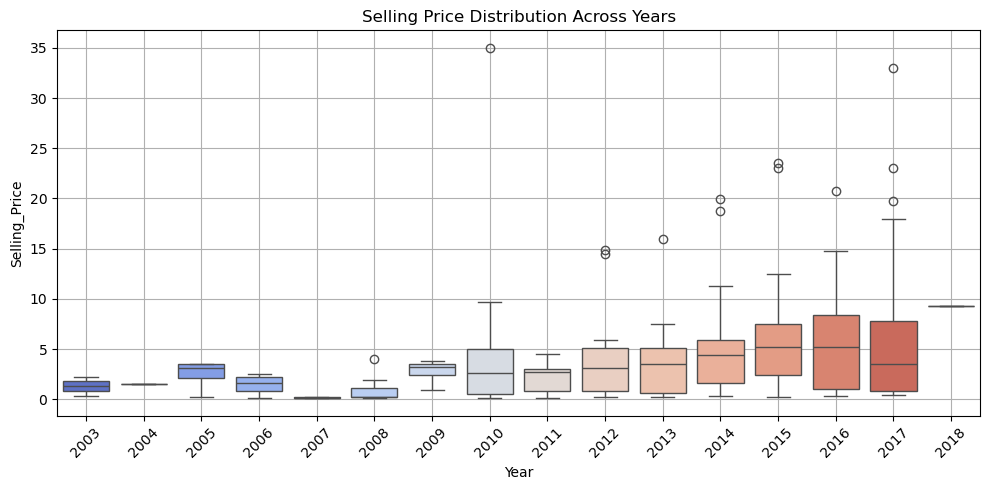

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Year', y='Selling_Price', palette='coolwarm')
plt.title('Selling Price Distribution Across Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


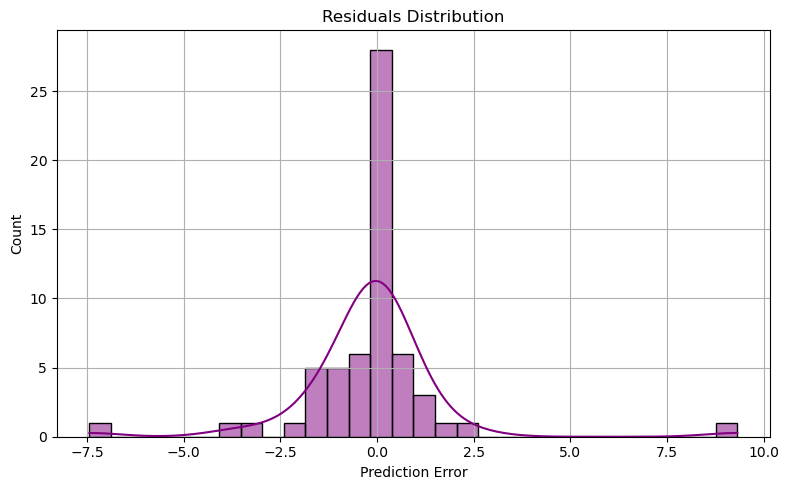

In [65]:
# Calculate residuals
y_pred = best_xgb.predict(preprocessor.transform(X_test))
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Residuals Distribution')
plt.xlabel('Prediction Error')
plt.grid(True)
plt.tight_layout()
plt.show()


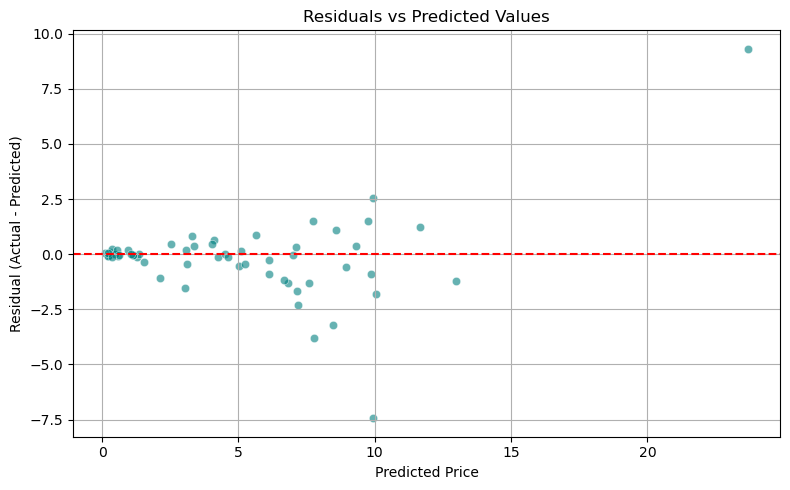

In [67]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
import joblib

# Final pipeline (preprocessor + best_xgb already trained)
final_model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', best_xgb)
])

# Save model
joblib.dump(final_model_pipeline, 'car_price_model.pkl')
print("Model saved as car_price_model.pkl")


Model saved as car_price_model.pkl
